# 使用基础的tf2函数实现ML分类问题

利用鸢尾花数据集，实现前向传播、反向传播，可视化loss曲线
使用最基础的全连接网络来训练一个多层感知机模型。这个模型中使用神经元模型来定义网络之间的连接

In [1]:
# 导入所需模块
import tensorflow as tf
from sklearn import datasets
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import time  ##1##

## 1、加载数据集
需要加载的数据有两大类，一是用于训练的数据，二是用于测试的数据
将原始数据进行分组，并将数据进行随机化。通过打乱数据的排布顺序可以避免网络学习过拟合。在分类的数据中关注的重点的数据内部的特征和结果，而不是数据采集到的顺序。
在时间序列的数据中，重点关注的是数据内部的特征和数据的时间关系，所以时间序列数据通常按照一定时间长度先分组，再根据分组随机化。

In [2]:
# 导入数据，分别为输入特征和标签
x_data = datasets.load_iris().data
y_data = datasets.load_iris().target


查看数据集内容

In [3]:
x_data_ = pd.DataFrame(x_data, columns=['花萼长度', '花萼宽度', '花瓣长度', '花瓣宽度']) # 为表格增加行索引（左侧）和列标签（上方）
pd.set_option('display.unicode.east_asian_width', True)  # 设置列名对齐
x_data_['类别'] = y_data  # 新加一列，列标签为‘类别’，数据为y_data
print("x_data add a column: \n", x_data_)

x_data add a column: 
      花萼长度  花萼宽度  花瓣长度  花瓣宽度  类别
0         5.1       3.5       1.4       0.2     0
1         4.9       3.0       1.4       0.2     0
2         4.7       3.2       1.3       0.2     0
3         4.6       3.1       1.5       0.2     0
4         5.0       3.6       1.4       0.2     0
..        ...       ...       ...       ...   ...
145       6.7       3.0       5.2       2.3     2
146       6.3       2.5       5.0       1.9     2
147       6.5       3.0       5.2       2.0     2
148       6.2       3.4       5.4       2.3     2
149       5.9       3.0       5.1       1.8     2

[150 rows x 5 columns]


In [4]:
# 随机打乱数据（因为原始数据是顺序的，顺序不打乱会影响准确率）
# seed: 随机数种子，是一个整数，当设置之后，每次生成的随机数都一样（为方便教学，以保每位同学结果一致）
np.random.seed(116)  # 使用相同的seed，保证输入特征和标签一一对应
np.random.shuffle(x_data)
np.random.seed(116)
np.random.shuffle(y_data)
tf.random.set_seed(116)

# 将打乱后的数据集分割为训练集和测试集，训练集为前120行，测试集为后30行
x_train = x_data[:-30]
y_train = y_data[:-30]
x_test = x_data[-30:]
y_test = y_data[-30:]

## 2、调整数据格式
要通过数据转换来讲原始的数据格式转化为tensor张量，从而才能输入到tf中进行计算
同时特征数据和原始数据还需对应匹配，这样网络才能正常计算输入到输出的loss

In [5]:
# 转换x的数据类型，否则后面矩阵相乘时会因数据类型不一致报错
x_train = tf.cast(x_train, tf.float32)
x_test = tf.cast(x_test, tf.float32)

# from_tensor_slices函数使输入特征和标签值一一对应。（把数据集分批次，每个批次batch组数据）
train_db = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
test_db = tf.data.Dataset.from_tensor_slices((x_test, y_test)).batch(32)

## 3、设置网络结构，初始化网络
这里设计了两个神经元模型，原始数据是四个特征数据对应一个输出特征。
第一个神经元四输入四输出，第二个神经元四输出三输出。网络参数的初始化使用随机数赋值，为了保证结果相同设置了随机数种子。

In [6]:
# 生成神经网络的参数，4个输入特征故，输入层为4个输入节点；因为3分类，故输出层为3个神经元
# 用tf.Variable()标记参数可训练
# 使用seed使每次生成的随机数相同（方便教学，使大家结果都一致，在现实使用时不写seed）
w1 = tf.Variable(tf.random.truncated_normal([4, 4], stddev=0.1, seed=1))
b1 = tf.Variable(tf.random.truncated_normal([4], stddev=0.1, seed=1))

w2 = tf.Variable(tf.random.truncated_normal([4, 3], stddev=0.1, seed=1))
b2 = tf.Variable(tf.random.truncated_normal([3], stddev=0.1, seed=1))

## 4、设置网络训练参数
一般网络训练的超参数都有：
学习率：用于反向传播时更新参数
迭代次数：网络进行前向传播加反向传播的循环次数

In [7]:
lr = 0.1  # 学习率为0.1
train_loss_results = []  # 将每轮的loss记录在此列表中，为后续画loss曲线提供数据
test_acc = []  # 将每轮的acc记录在此列表中，为后续画acc曲线提供数据
epoch = 500  # 循环500轮
loss_all = 0  # 每轮分4个step，loss_all记录四个step生成的4个loss的和

## 5、开始训练
在训练过程中，流程为：
分组加载数据>进行前向传播>根据损失函数计算损失>计算参数对损失函数的梯度>由梯度和学习率更新网络网络中的参数>完成一次迭代>测试当前模型的准确性>开始下一次循环>直到循环结束

In [8]:
# 训练部分
now_time = time.time()  ##2##
for epoch in range(epoch):  # 数据集级别的循环，每个epoch循环一次数据集
    for step, (x_train, y_train) in enumerate(train_db):  # batch级别的循环 ，每个step循环一个batch
        with tf.GradientTape() as tape:  # with结构记录梯度信息
            y = tf.matmul(x_train, w1) + b1  # 神经网络乘加运算
            y = tf.matmul(y, w2) + b2  # 神经网络乘加运算
            y = tf.nn.softmax(y)  # 使输出y符合概率分布（此操作后与独热码同量级，可相减求loss）
            y_ = tf.one_hot(y_train, depth=3)  # 将标签值转换为独热码格式，方便计算loss和accuracy
            loss = tf.reduce_mean(tf.square(y_ - y))  # 采用均方误差损失函数mse = mean(sum(y-out)^2)
            loss_all += loss.numpy()  # 将每个step计算出的loss累加，为后续求loss平均值提供数据，这样计算的loss更准确
        # 计算loss对各个参数的梯度
        grads = tape.gradient(loss, [w1, b1, w2, b2])
        # 实现梯度更新 w1 = w1 - lr * w1_grad    b = b - lr * b_grad
        w1.assign_sub(lr * grads[0])  # 参数w1自更新
        b1.assign_sub(lr * grads[1])  # 参数b自更新
        w2.assign_sub(lr * grads[2])    # 参数w2自更新
        b2.assign_sub(lr * grads[3])    # 参数b2自更新

    # 每个epoch，打印loss信息
    print("Epoch {}, loss: {}".format(epoch, loss_all / 4))
    train_loss_results.append(loss_all / 4)  # 将4个step的loss求平均记录在此变量中
    loss_all = 0  # loss_all归零，为记录下一个epoch的loss做准备

    # 测试部分
    # total_correct为预测对的样本个数, total_number为测试的总样本数，将这两个变量都初始化为0
    total_correct, total_number = 0, 0
    for x_test, y_test in test_db:
        # 使用更新后的参数进行预测
        y = tf.matmul(x_test, w1) + b1
        y = tf.matmul(y, w2) + b2
        y = tf.nn.softmax(y)
        pred = tf.argmax(y, axis=1)  # 返回y中最大值的索引，即预测的分类
        # 将pred转换为y_test的数据类型
        pred = tf.cast(pred, dtype=y_test.dtype)
        # 若分类正确，则correct=1，否则为0，将bool型的结果转换为int型
        correct = tf.cast(tf.equal(pred, y_test), dtype=tf.int32)
        # 将每个batch的correct数加起来
        correct = tf.reduce_sum(correct)
        # 将所有batch中的correct数加起来
        total_correct += int(correct)
        # total_number为测试的总样本数，也就是x_test的行数，shape[0]返回变量的行数
        total_number += x_test.shape[0]
    # 总的准确率等于total_correct/total_number
    acc = total_correct / total_number
    test_acc.append(acc)
    print("Test_acc:", acc)
    print("--------------------------")
total_time = time.time() - now_time  ##3##
print("total_time", total_time)  ##4##

Epoch 0, loss: 0.22589663416147232
Test_acc: 0.0
--------------------------
Epoch 1, loss: 0.22404584288597107
Test_acc: 0.16666666666666666
--------------------------
Epoch 2, loss: 0.22244294360280037
Test_acc: 0.16666666666666666
--------------------------
Epoch 3, loss: 0.22097110748291016
Test_acc: 0.16666666666666666
--------------------------
Epoch 4, loss: 0.21955448389053345
Test_acc: 0.16666666666666666
--------------------------
Epoch 5, loss: 0.21814147755503654
Test_acc: 0.16666666666666666
--------------------------
Epoch 6, loss: 0.21669594943523407
Test_acc: 0.16666666666666666
--------------------------
Epoch 7, loss: 0.2151923067867756
Test_acc: 0.16666666666666666
--------------------------
Epoch 8, loss: 0.21361201629042625
Test_acc: 0.16666666666666666
--------------------------
Epoch 9, loss: 0.2119409553706646
Test_acc: 0.16666666666666666
--------------------------
Epoch 10, loss: 0.2101668044924736
Test_acc: 0.16666666666666666
--------------------------
Epoch 

## 6、评价计算结果以及可视化
在上面的测试过程中已经分析了网络输出的准确度acc，和测试集损失。
这里将前面采集到的数据进行可视化。训练过程中的损失值和准确度是评判网络准确性的两个重要因素。

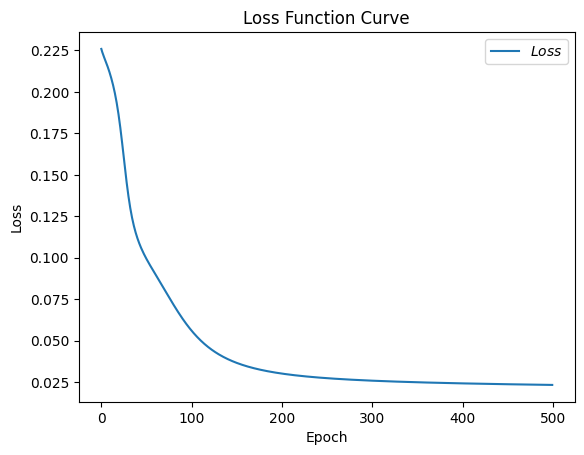

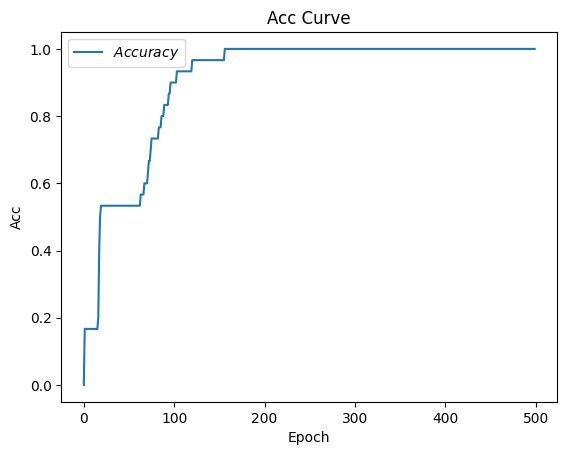

In [9]:
# 绘制 loss 曲线
plt.title('Loss Function Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Loss')  # y轴变量名称
plt.plot(train_loss_results, label="$Loss$")  # 逐点画出trian_loss_results值并连线，连线图标是Loss
plt.legend()  # 画出曲线图标
plt.show()  # 画出图像

# 绘制 Accuracy 曲线
plt.title('Acc Curve')  # 图片标题
plt.xlabel('Epoch')  # x轴变量名称
plt.ylabel('Acc')  # y轴变量名称
plt.plot(test_acc, label="$Accuracy$")  # 逐点画出test_acc值并连线，连线图标是Accuracy
plt.legend()
plt.show()